This notebook demonstrates how to load the appropriate data for different training experiments and their corresponding evaluations, once the data has been downloaded from Zenodo (see the `data_download.ipynb` notebook).

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

Before loading the data, we define a few basic functions for visualization.

In [2]:
def plot_predictor_map(predictor, var_name, domain, time_index=0, figsize=(8,8), cmap='viridis'):
    data_to_plot = predictor[var_name].isel(time=time_index)
    
    central_longitude = 180 if domain == 'NZ' else 0 if domain == 'ALPS' else None
    
    plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_longitude))
    
    data_to_plot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap)
    
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    plt.title(f'Variable {var_name} from predictor set ({domain}) for time step {time_index}')
    plt.show()

def plot_orog_map(orog, domain, figsize=(8,8), cmap='terrain'):
    data_to_plot = orog['orog']
    
    central_longitude = 180 if domain == 'NZ' else 0 if domain == 'ALPS' else None
    
    plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_longitude))

    if domain == 'NZ':
        data_to_plot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap)
    elif domain == 'ALPS':
        cs = ax.pcolormesh(data_to_plot['lon'], data_to_plot['lat'],
                           data_to_plot,
                           transform=ccrs.PlateCarree(),
                           cmap=cmap)
    
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    plt.title(f'Orography ({domain})')
    plt.show()

def plot_predictand_map(predictand, var_name, domain, time_index, figsize=(8,8), cmap='viridis'):
    data_to_plot = predictand[var_name].isel(time=time_index)
    
    central_longitude = 180 if domain == 'NZ' else 0 if domain == 'ALPS' else None
    
    plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=central_longitude))

    if domain == 'NZ':
        data_to_plot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap)
    elif domain == 'ALPS':
        cs = ax.pcolormesh(data_to_plot['lon'], data_to_plot['lat'],
                           data_to_plot,
                           transform=ccrs.PlateCarree(),
                           cmap=cmap)
    
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    plt.title(f'Variable {var_name} from predictand set ({domain}) for time step {time_index}')
    plt.show()

## Training Experiments

Thanks to the dataset structure across domains, loading the different experiments is quite straightforward. We will focus on the `NZ` domain corresponding to New Zealand.

In [4]:
domain = 'NZ'
DATA_PATH = f'./CORDEXBench/{domain}/{domain}_domain'

Below, we can select which training experiment to load from the following options:

- ESD Pseudo Reality (`ESD_pseudo_reality`)
- Emulator (`Emulator_hist_fut`)

Depending on the selection, the code will load the corresponding predictors and predictands for the chosen experiment. For this tutorial, we will focus on `Emulator_hist_fut`. This dataset is similar to the one we presented in the previous slides for illustration purposes.

In [5]:
training_experiment = 'Emulator_hist_future'

Based on the selected experiment, we choose the appropriate period and climate model, as the NetCDF files are named according to these parameters.

In [6]:
# Set the period
if training_experiment == 'ESD_pseudo_reality':
    period_training = '1961-1980'
elif training_experiment == 'Emulator_hist_future':
    period_training = '1961-1980_2080-2099'
else:
    raise ValueError('Provide a valid date')

# Set the GCM
if domain == 'ALPS':
    gcm_name = 'CNRM-CM5'
elif domain == 'NZ':
    gcm_name = 'ACCESS-CM2'

For each training experiment, we obtain a set of predictors (X) and the corresponding predictand (y), both corresponding to simulations of the same RCM. This implies that we will train the RCM emulation following the **Perfect Framework**.

The predictors consist of the following 15 large-scale variables:

- Air temperature (`t`)
- Geopotential Height (`z`)
- Zonal Wind Component (`u`)
- Meridional Wind Component (`v`)
- Specific Humidity (`q`)

at 3 different height levels (500, 700 and 850 hPa), with a spatial resolution of approximately 150 km and daily temporal resolution.

In [15]:
predictor_filename = f'{DATA_PATH}/train/{training_experiment}/predictors/{gcm_name}_{period_training}.nc'
predictor = xr.open_dataset(predictor_filename)

In [16]:
print(predictor)

<xarray.Dataset> Size: 224MB
Dimensions:  (time: 14600, lat: 16, lon: 16)
Coordinates:
  * lon      (lon) float64 128B 157.5 159.5 161.5 163.5 ... 183.5 185.5 187.5
  * lat      (lat) float64 128B -55.5 -53.5 -51.5 -49.5 ... -29.5 -27.5 -25.5
  * time     (time) datetime64[ns] 117kB 1961-01-01 1961-01-02 ... 2099-12-31
Data variables: (12/15)
    u_850    (time, lat, lon) float32 15MB ...
    u_700    (time, lat, lon) float32 15MB ...
    u_500    (time, lat, lon) float32 15MB ...
    v_850    (time, lat, lon) float32 15MB ...
    v_700    (time, lat, lon) float32 15MB ...
    v_500    (time, lat, lon) float32 15MB ...
    ...       ...
    t_850    (time, lat, lon) float32 15MB ...
    t_700    (time, lat, lon) float32 15MB ...
    t_500    (time, lat, lon) float32 15MB ...
    z_850    (time, lat, lon) float32 15MB ...
    z_700    (time, lat, lon) float32 15MB ...
    z_500    (time, lat, lon) float32 15MB ...
Attributes: (12/259)
    CDI:                  Climate Data Interface ver

The data can be easily visualized using Cartopy.

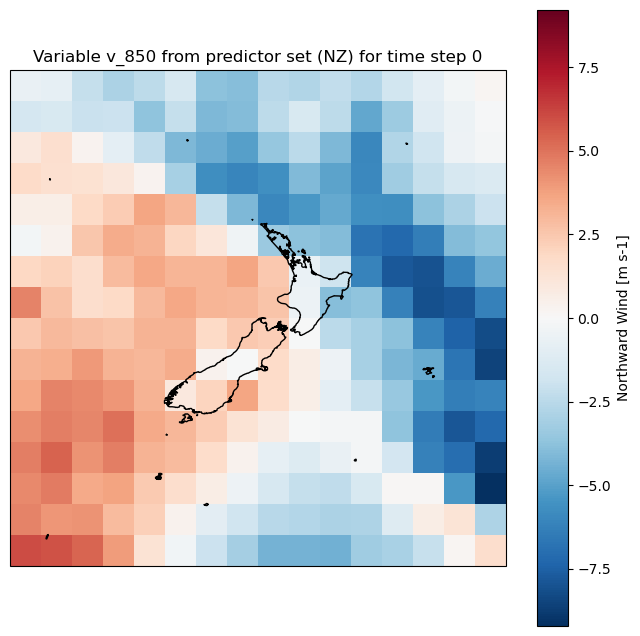

In [18]:
plot_predictor_map(predictor=predictor, var_name='v_850', domain=domain, cmap='RdBu_r')

Finally, we can load the predictand, which is the data used as the target. The same NetCDF file contains both variables considered as predictands in this benchmark: daily maximum temperature (tasmax) and precipitation (pr). For this tutorial we will focus on the maximum temperature (`tasmax`).

In [23]:
var_target = 'tasmax'

predictand_filename = f'{DATA_PATH}/train/{training_experiment}/target/pr_tasmax_{gcm_name}_{period_training}.nc'
predictand = xr.open_dataset(predictand_filename)
predictand = predictand[[var_target]]

In [24]:
print(predictand)

<xarray.Dataset> Size: 957MB
Dimensions:  (time: 14600, lat: 128, lon: 128)
Coordinates:
  * time     (time) datetime64[ns] 117kB 1961-01-01 1961-01-02 ... 2099-12-31
  * lon      (lon) float32 512B 166.0 166.1 166.3 166.4 ... 179.5 179.6 179.7
  * lat      (lat) float32 512B -47.56 -47.46 -47.35 ... -34.15 -34.04 -33.93
Data variables:
    tasmax   (time, lat, lon) float32 957MB ...
Attributes: (12/28)
    CDI:             Climate Data Interface version 1.9.5 (http://mpimet.mpg....
    history:         Tue Mar 12 14:54:26 2024: cdo merge /nesi/project/niwa00...
    source:          CSIRO conformal-cubic model. Input file: surf.ccam_12km....
    Conventions:     CF-1.7
    title:           CCAM simulation data
    il:              288
    ...              ...
    BC_version:      no output bias correction
    CMOR_v:          v1.0 Public
    CDO_call:        daymean computed on hourly data
    project:         NIWA CMIP6 Downscaling
    contact:         Peter Gibson (peter.gibson@niwa.

In this case, the spatial resolution of the predictand is ~11 km, so we will try to learn the downscaling function of an RCM, going from a spatial resolution of ~150 km to ~11 km.

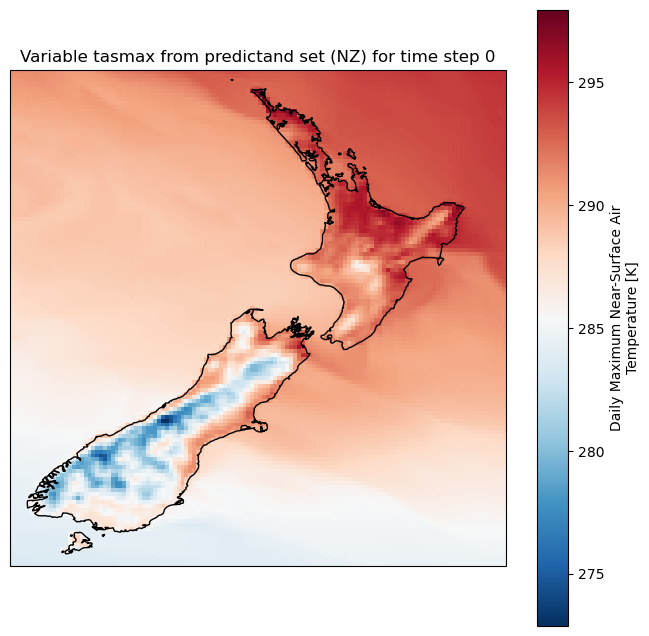

In [26]:
plot_predictand_map(predictand=predictand, var_name=var_target, time_index=0, domain=domain, cmap='RdBu_r')

Unlike the NZ domain, for the ALPS domain the predictand simulations are provided on a curvilinear Lambert projection, which affects the visualization in Cartopy. However, the data can still be used for model training without additional processing, as it remains a square array. This ensures that models can be trained in the same way regardless of the domain.

In the following cell, we visualize the raw NumPy array for the ALPS domain.

In [27]:
if domain == 'ALPS':
    predictand_tasmax_array = predictand['tasmax'].values
    plt.imshow(predictand_tasmax_array[0, :], origin='lower')
    plt.colorbar()
    plt.show()
else:
    print('This cell requires the ALPS domain')

This cell requires the ALPS domain


## Evaluation Experiments

Similarly to the training data, the evaluation data for the different experiments can also be loaded in the same format. In line with the introduction we made in class, we will test two different evaluation experiments:

- **Soft-transferability**: Can the RCM emulator interpolate to an unseen period (within the same RCM run used for training)?
- **Hard-transferability**: Can the RCM emulator be ran on GCM different from the one that drove the RCM used in training?

In [30]:
evaluation_experiment = 'soft-transferability'

Below, we define the data to be loaded for each evaluation experiment.

In [31]:
# Define experiment settings
evaluation_experiment_settings = {
    "Emulator_hist_future": {
        "soft-transferability": ("historical", "perfect", True),
        "hard-transferability": ("mid_end_century", "imperfect", False),
    },
}

# Get settings for the chosen experiments
period, mode, same_gcm_as_train = evaluation_experiment_settings[training_experiment][evaluation_experiment]

In [32]:
# Map periods to dates
period_dates = {
    "historical": "1981-2000",
    "mid_century": "2041-2060",
    "end_century": "2080-2099",
    "mid_end_century": ["2041-2060", "2080-2099"],
}

period_date = period_dates[period]

In [33]:
# GCM selection by domain and training setup
gcm_train = {"NZ": "ACCESS-CM2", "ALPS": "CNRM-CM5"}
gcm_eval = {"NZ": "EC-Earth3", "ALPS": "MPI-ESM-LR"}

if same_gcm_as_train:
    gcm_name = gcm_train[domain]
else:
    gcm_name = gcm_eval[domain]

With the option set, we can proceed to load the corresponding predictor data.

In [34]:
if period == 'mid_end_century':
    predictor_evaluation_filename_mid_century = f'{DATA_PATH}/test/mid_century/predictors/{mode}/{gcm_name}_2041-2060.nc'
    predictor_evaluation_mid = xr.open_dataset(predictor_evaluation_filename_mid_century)
    
    predictor_evaluation_filename_end_century = f'{DATA_PATH}/test/end_century/predictors/{mode}/{gcm_name}_2080-2099.nc'
    predictor_evaluation_end = xr.open_dataset(predictor_evaluation_filename_end_century)

    predictor_evaluation = xr.merge([predictor_evaluation_mid, predictor_evaluation_end])
else:
    predictor_evaluation_filename = f'{DATA_PATH}/test/{period}/predictors/{mode}/{gcm_name}_{period_date}.nc'
    predictor_evaluation = xr.open_dataset(predictor_evaluation_filename)

It is important to note that only the predictors (X) for each evaluation experiment will be loaded. At this stage of development of the benchmark, it is not possible to properly evaluate the RCM emulator, since the ground-truth data (the corresponding RCM simulation) is not yet available. When the final version of the benchmark is released, this data will also be provided so that users can assess how different DL architectures perform. For now, we can practice training the models and running them within these evaluation experiments.

In [35]:
print(predictor_evaluation)

<xarray.Dataset> Size: 112MB
Dimensions:  (time: 7300, lat: 16, lon: 16)
Coordinates:
  * lon      (lon) float64 128B 157.5 159.5 161.5 163.5 ... 183.5 185.5 187.5
  * lat      (lat) float64 128B -55.5 -53.5 -51.5 -49.5 ... -29.5 -27.5 -25.5
  * time     (time) datetime64[ns] 58kB 1981-01-01 1981-01-02 ... 2000-12-31
Data variables: (12/15)
    u_850    (time, lat, lon) float32 7MB ...
    u_700    (time, lat, lon) float32 7MB ...
    u_500    (time, lat, lon) float32 7MB ...
    v_850    (time, lat, lon) float32 7MB ...
    v_700    (time, lat, lon) float32 7MB ...
    v_500    (time, lat, lon) float32 7MB ...
    ...       ...
    t_850    (time, lat, lon) float32 7MB ...
    t_700    (time, lat, lon) float32 7MB ...
    t_500    (time, lat, lon) float32 7MB ...
    z_850    (time, lat, lon) float32 7MB ...
    z_700    (time, lat, lon) float32 7MB ...
    z_500    (time, lat, lon) float32 7MB ...
Attributes: (12/259)
    CDI:                  Climate Data Interface version 1.9.5 (ht

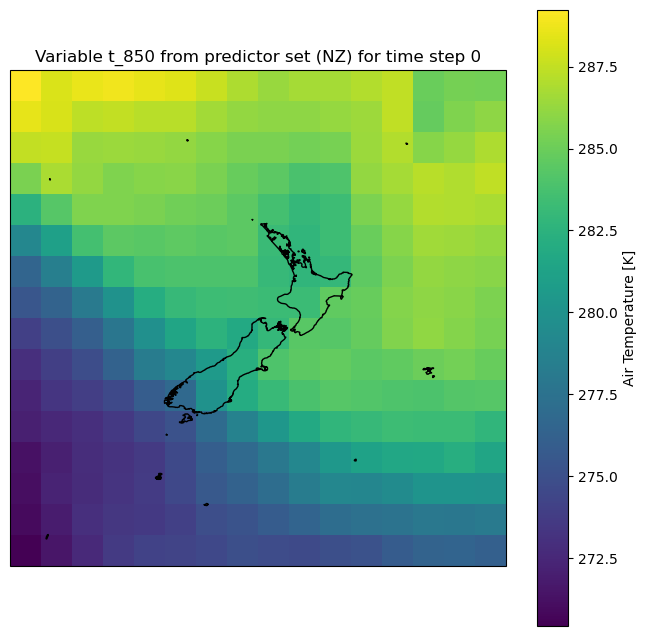

In [36]:
plot_predictor_map(predictor=predictor_evaluation, var_name='t_850', domain=domain)